In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

PROJECT_ROOT = os.path.abspath(os.path.join(".."))
PROCESSED_DATA_PATH = os.path.join(PROJECT_ROOT, "data", "processed", "air_quality_processed.csv")
df = pd.read_csv(PROCESSED_DATA_PATH)
print("Data shape:", df.shape)
df.head()

Data shape: (5530918, 23)


,date,sitename,county,aqi,status,so2,co,o3,o3_8hr,pm10,pm2.5,no2,nox,no,windspeed,winddirec,co_8hr,pm2.5_avg,pm10_avg,so2_avg,longitude,latitude,siteid
0,2016-11-25 13:00:00,Keelung,Keelung City,30.0,Good,1.1,0.22,37.0,35.0,14.0,4.0,3.0,4.7,1.7,2.4,79.0,0.28,3.0,9.0,2.0,121.760056,25.129167,1.0
1,2016-11-25 14:00:00,Keelung,Keelung City,30.0,Good,1.1,0.22,38.0,35.0,12.0,4.0,3.4,4.9,1.5,3.1,73.0,0.28,3.0,9.0,2.0,121.760056,25.129167,1.0
2,2016-11-25 15:00:00,Keelung,Keelung City,30.0,Good,1.0,0.22,38.0,35.0,14.0,5.0,3.7,5.4,1.7,3.0,79.0,0.28,4.0,9.0,2.0,121.760056,25.129167,1.0
3,2016-11-25 16:00:00,Keelung,Keelung City,30.0,Good,1.1,0.21,38.0,35.0,17.0,6.0,3.3,4.8,1.4,3.0,74.0,0.28,4.0,10.0,2.0,121.760056,25.129167,1.0
4,2016-11-25 17:00:00,Keelung,Keelung City,31.0,Good,1.0,0.23,38.0,36.0,17.0,6.0,3.2,4.7,1.5,3.3,81.0,0.28,4.0,10.0,2.0,121.760056,25.129167,1.0


# Câu hỏi 1: Phân tích biến động theo thời gian (Temporal Analysis)

### 1. Câu hỏi
Mô hình biến động của các chất ô nhiễm chính (**PM2.5, O3, NOx**) thay đổi như thế nào theo các khung thời gian: 
- **Giờ trong ngày (Diurnal)**  
- **Ngày trong tuần (Weekly)**  
- **Theo mùa (Seasonal)**  

Có sự khác biệt rõ rệt nào giữa hành vi của:  
- **Các chất gây ô nhiễm do giao thông:** NOx  
- **Các chất ô nhiễm thứ cấp:** O3  

vào **giờ cao điểm** không?

### 2. Động lực và lợi ích

#### Tại sao cần nghiên cứu
- Hiểu được **chu kỳ ô nhiễm** giúp xác định **nguồn gốc phát thải**  
  - Ví dụ: đỉnh ô nhiễm vào 7–9h sáng gợi ý **nguồn gốc giao thông**

#### Lợi ích
- Cung cấp thông tin để **người dân biết thời điểm nào trong ngày nên hạn chế hoạt động ngoài trời**

#### Đối tượng quan tâm
- **Người dân**: để bảo vệ sức khỏe  
- **Chính quyền địa phương**: để điều tiết giao thông

#### Ứng dụng thực tế
- Giúp đưa ra **khuyến cáo sức khỏe** hoặc **chính sách hạn chế xe cộ vào giờ cao điểm**

## A. Preprocessing (Tiền xử lý dữ liệu)

### A.1 Written Explanation

Trước khi phân tích, cần chuẩn bị dữ liệu để đảm bảo **tính chính xác** và thuận tiện cho phân tích theo thời gian.

##### 1. Chuyển cột `date` sang dạng datetime
- **Mục đích:** dễ dàng trích xuất **giờ, ngày trong tuần, tháng, mùa**.

##### 2. Loại bỏ giá trị thiếu (NaN):
- Các giá trị thiếu trong dữ liệu đã được xử lý.

##### 3. Tạo các cột bổ sung
- `hour` → giờ trong ngày (0–23)  
- `weekday` → ngày trong tuần (0–6, từ thứ Hai đến Chủ nhật)  
- `month` → tháng  
- `season` → mùa (Ví dụ: Xuân: 3–5, Hạ: 6–8, Thu: 9–11, Đông: 12–2)

##### 4. Lọc các chất ô nhiễm chính
- Chỉ giữ lại **PM2.5, NOx, O3**.

### A.2 Code Implementation

In [18]:
# 1. Chuyển cột 'date' sang kiểu datetime
df['date'] = pd.to_datetime(df['date'])

# 2. Tạo các cột dựa trên thời gian
df['hour'] = df['date'].dt.hour         # Giờ trong ngày
df['weekday'] = df['date'].dt.weekday   # Thứ trong tuần (0=Thứ Hai)
df['month'] = df['date'].dt.month       # Tháng

# Thêm thông tin mùa
def month_to_season(month):
    if month in [12, 1, 2]: 
        return 'Winter'
    elif month in [3, 4, 5]: 
        return 'Spring'
    elif month in [6, 7, 8]: 
        return 'Summer'
    else: 
        return 'Autumn'

# Áp dụng cho cột month
df['season'] = df['month'].apply(month_to_season)
# 3. Lọc chỉ các chất ô nhiễm chính
pollutants = ['pm2.5', 'nox', 'o3']
df_pollutants = df[['date', 'hour', 'weekday', 'month', 'season'] + pollutants]

# Xem trước dữ liệu
df_pollutants.head()


,date,hour,weekday,month,season,pm2.5,nox,o3
0,2016-11-25 13:00:00,13,4,11,Autumn,4.0,4.7,37.0
1,2016-11-25 14:00:00,14,4,11,Autumn,4.0,4.9,38.0
2,2016-11-25 15:00:00,15,4,11,Autumn,5.0,5.4,38.0
3,2016-11-25 16:00:00,16,4,11,Autumn,6.0,4.8,38.0
4,2016-11-25 17:00:00,17,4,11,Autumn,6.0,4.7,38.0


## B. Analysis (Phân tích)

### B.1 Written Explanation

#### 1. Phân tích biến động theo giờ trong ngày (Diurnal Pattern)
- Tính **trung bình nồng độ** của **PM2.5, NOx, O3** theo từng giờ.  
- **Mục đích:** xác định **giờ cao điểm ô nhiễm**

#### 2. Phân tích biến động theo ngày trong tuần (Weekly Pattern)
- Trung bình nồng độ theo **weekday**  
- **Mục đích:** xem liệu **cuối tuần có giảm ô nhiễm** do giao thông hay không

#### 3. Phân tích theo mùa (Seasonal Pattern)
- Trung bình theo **season**.
- **Mục đích:** xem chất ô nhiễm tăng cao vào **mùa khô** hay **mùa lạnh**

#### 4. So sánh ô nhiễm giao thông vs thứ cấp
- **Ô nhiễm giao thông:** NOx  
- **Ô nhiễm thứ cấp:** O3  
- So sánh **peak hour patterns** để kiểm tra khác biệt

### 5. Visualization
- **Line plot:** cho diurnal pattern  
- **Bar plot:** cho weekly pattern  
- **Boxplot hoặc line plot:** cho seasonal trend

### B.2 Code Implementation

In [19]:
# Tính trung bình theo giờ
hourly_avg = df_pollutants.groupby('hour')[pollutants].mean().reset_index()

# Tính trung bình theo ngày
weekly_avg = df_pollutants.groupby('weekday')[pollutants].mean().reset_index()

# Seasonal pattern (Biến động theo mùa)
# Tính trung bình theo mùa
season_avg = df_pollutants.groupby('season')[pollutants].mean().reset_index()

# Chuyển sang dạng dài để dùng hue
season_melted = season_avg.melt(id_vars='season', value_vars=pollutants,
                                var_name='Pollutant', value_name='Average_Concentration')

# C. Results & Interpretation

## C.1 Visualizations

Ba chất ô nhiễm chính (**PM2.5, NOx, O3**) được phân tích dựa trên ba biểu đồ:

- **Diurnal Pattern:** Biến động theo giờ trong ngày
- **Weekly Pattern:** Biến động theo ngày trong tuần  
- **Seasonal Pattern:** Biến động theo mùa  

### 1. Diurnal Pattern – Biến động theo giờ trong ngày 

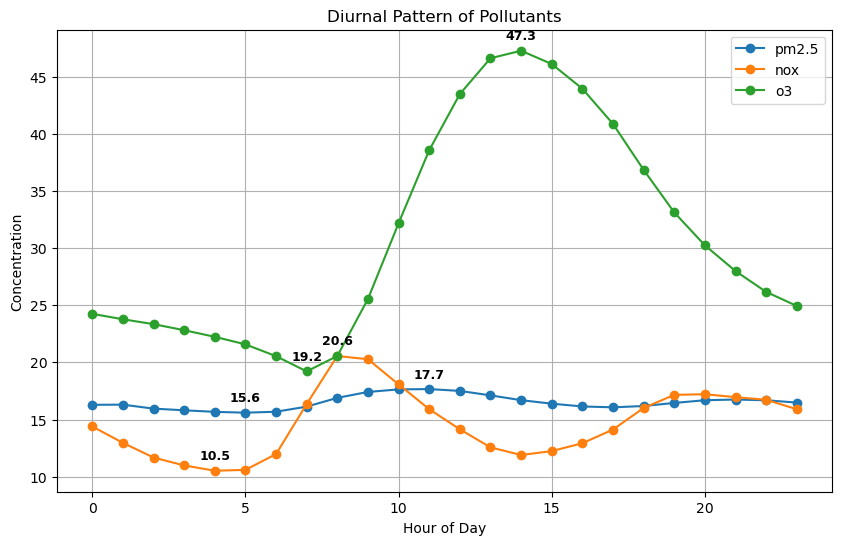

In [20]:
# 1. Diurnal pattern (Biến động theo giờ)
plt.figure(figsize=(10,6))

for p in pollutants:
    plt.plot(hourly_avg['hour'], hourly_avg[p], marker='o', label=p)

    # tìm max và min
    max_idx = hourly_avg[p].idxmax()
    min_idx = hourly_avg[p].idxmin()

    for idx in [max_idx, min_idx]:
        x = hourly_avg.loc[idx, 'hour']
        y = hourly_avg.loc[idx, p]
        plt.annotate(f"{y:.1f}",
                     (x, y),
                     textcoords="offset points",
                     xytext=(0,8),
                     ha='center',
                     fontsize=9,
                     fontweight='bold')

plt.title("Diurnal Pattern of Pollutants")
plt.xlabel("Hour of Day")
plt.ylabel("Concentration")
plt.legend()
plt.grid(True)
plt.show()

### Nhận xét về biến động theo giờ trong ngày:

#### NOx (Màu Cam – Ô nhiễm sơ cấp, chủ yếu từ giao thông)
- Thể hiện **hai đỉnh rõ rệt**, đặc trưng cho các giờ cao điểm giao thông  
- **Đỉnh buổi sáng:** ~20.6 vào khoảng 8:00–9:00  
- **Đỉnh buổi tối:** ~17.0–17.3 vào khoảng 19:00–21:00  
- **Nồng độ thấp nhất:** ~10.5 vào rạng sáng (khoảng 4:00–5:00)  

**Nhận xét:** Mức NOx buổi sáng cao hơn buổi tối, phản ánh cường độ giao thông buổi sáng mạnh hơn.


#### O₃ (Màu Xanh Lá – Ô nhiễm thứ cấp)
- Có **một đỉnh duy nhất** vào giữa ngày  
- **Nồng độ cực đại:** ~47.3 tại khoảng 14:00  
- **Nồng độ thấp nhất:** ~19.2 vào rạng sáng (khoảng 6:00)  
- Sự hình thành O₃ gắn liền với **các phản ứng quang hóa dưới bức xạ mặt trời**, sử dụng các tiền chất NOx và VOCs  

**Giải thích:** O₃ thấp vào rạng sáng do thiếu bức xạ mặt trời và hiện tượng *NO titration* làm tiêu hao O₃.


#### PM2.5 (Màu Xanh Dương)
- Biến động trong **biên độ hẹp**, dao động khoảng 15.6–17.7  
- Xuất hiện **hai đỉnh nhẹ**:
  - **Buổi sáng:** ~17.7 vào khoảng 10:00–11:00  
  - **Buổi tối:** ~16.9–17.0 vào khoảng 20:00–22:00  
- Phản ánh **nguồn phát thải đa dạng**, bao gồm giao thông, sinh hoạt và nền khu vực


### Tổng hợp
- NOx đạt cực đại vào các **giờ cao điểm giao thông**, đặc biệt là buổi sáng  
- O₃ đạt đỉnh vào **giữa trưa – đầu giờ chiều** khi điều kiện bức xạ mặt trời thuận lợi  
- PM2.5 tương đối **ổn định**, cho thấy ảnh hưởng của cả nguồn phát thải tại chỗ và nền khu vực  

### Kết luận
Ô nhiễm sơ cấp (**NOx**) chịu chi phối mạnh bởi **hoạt động giao thông và hành vi con người**, trong khi ô nhiễm thứ cấp (**O₃**) phụ thuộc chủ yếu vào **điều kiện khí tượng và bức xạ mặt trời**.

### 2. Weekly Pattern – Biến động theo ngày trong tuần 

<Figure size 1000x600 with 0 Axes>

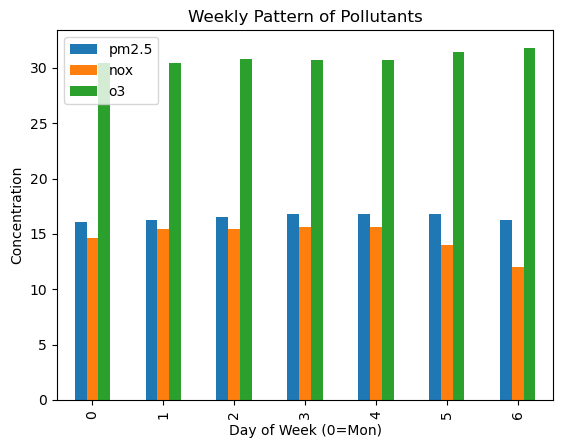

In [21]:
# 2. Weekly pattern (Biến động theo ngày trong tuần)
plt.figure(figsize=(10,6))
weekly_avg.plot(x='weekday', y=pollutants, kind='bar')
plt.title("Weekly Pattern of Pollutants")  
plt.xlabel("Day of Week (0=Mon)")         
plt.ylabel("Concentration")                
plt.show()

### Nhận xét về biến động theo ngày trong tuần:
Biểu đồ thể hiện sự biến động trung bình theo **ngày trong tuần**  
*(0 = Thứ Hai … 6 = Chủ Nhật)* của ba chất ô nhiễm: **PM2.5, NOx và O₃**.  

#### NOx – Ô nhiễm giao thông (màu cam)

- Cao và ổn định trong các ngày làm việc (**Thứ 2–Thứ 6**), dao động quanh **~15–16**
- Giảm rõ rệt vào cuối tuần, đặc biệt **Chủ Nhật (~12)**

Điều này phản ánh rất rõ **nguồn phát thải giao thông và hoạt động công nghiệp**, vốn giảm mạnh vào cuối tuần.

#### PM2.5 – Bụi mịn (màu xanh dương)

- Biến động nhỏ, tương đối ổn định suốt tuần (**~16–17**)
- Không có sự sụt giảm mạnh vào cuối tuần như NOx

Cho thấy **PM2.5 có nguồn phát thải đa dạng**: không chỉ từ giao thông mà còn từ công nghiệp nền, đốt nhiên liệu, bụi thứ cấp và điều kiện khí tượng.


#### O₃ – Ô nhiễm thứ cấp (màu xanh lá)

- Có xu hướng **tăng nhẹ về cuối tuần**, cao nhất vào **Thứ 7–Chủ Nhật (~31–32)**

Đây là **hiệu ứng cuối tuần (Weekend Effect)**:
- NOx giảm -> giảm hiện tượng *NO titration* (NO tiêu thụ O₃) ($\text{NO} + \text{O}_3 \rightarrow \text{NO}_2 + \text{O}_2$.)
- O₃ tồn tại lâu hơn và tích tụ nhiều hơn

#### 4. Tổng hợp & Diễn giải

- **Ngày làm việc**:  
  - NOx cao -> chi phối bởi giao thông
- **Cuối tuần**:
  - NOx giảm mạnh  
  - PM2.5 gần như không đổi  
  - O₃ tăng nhẹ  
-> **Không khí cuối tuần không đồng nghĩa là sạch hơn**, đặc biệt khi xét theo O₃.

#### Kết luận

- **NOx** phản ánh rõ chu kỳ hoạt động của con người  
- **O₃** chịu ảnh hưởng mạnh bởi cơ chế hóa học khí quyển, không giảm theo giao thông  
- **PM2.5** mang tính nền và tích tụ, ít nhạy với chu kỳ tuần

### 3. Seasonal Pattern – Biến động theo mùa

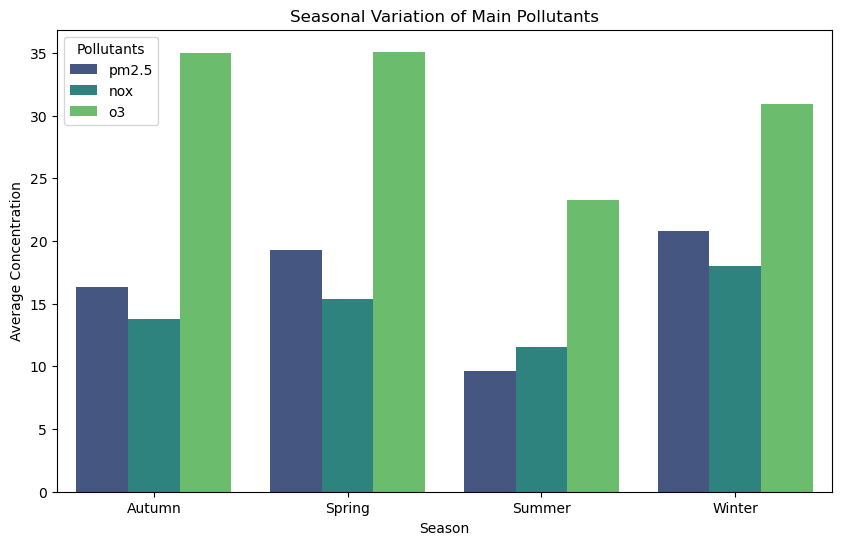

In [22]:
# 3. Seasonal pattern (Biến động theo mùa)
# Vẽ bar plot
plt.figure(figsize=(10,6))
sns.barplot(x='season', y='Average_Concentration', hue='Pollutant', data=season_melted, palette='viridis')

plt.title("Seasonal Variation of Main Pollutants")  
plt.xlabel("Season")                               
plt.ylabel("Average Concentration")                
plt.legend(title="Pollutants")                     
plt.show()

### Nhận xét về biến động theo mùa:

#### PM2.5 (Màu Xanh Đậm)

- **Nồng độ trung bình theo mùa:**
  - Mùa Đông: ~20.8 (cao nhất)
  - Mùa Hè: ~9.6 (thấp nhất)
  - Mùa Thu & Xuân: khoảng 16–19

- **Nhận xét:**
  - PM2.5 tăng vào mùa Đông do điều kiện khí tượng bất lợi (ít gió, nghịch nhiệt, tán phát thấp) và gia tăng sưởi ấm, hoạt động sinh hoạt.
  - Mùa Hè thấp nhất nhờ khí hậu nóng, gió và mưa làm loãng và rửa trôi bụi.

#### NOx (Màu Xanh Lơ)

- **Nồng độ trung bình theo mùa:**
  - Mùa Đông: ~18 (cao nhất)
  - Mùa Thu: ~13.8 (thấp nhất)

- **Nhận xét:**
  - NOx chịu chi phối bởi hoạt động giao thông và phát thải từ nhiên liệu.
  - Mùa Đông tăng do khí tượng hạn chế khuếch tán và có thể do sưởi ấm, đốt nhiên liệu.
  - Mùa Hè và Thu thấp hơn nhờ khuếch tán tốt hơn.

#### O₃ (Màu Xanh Lá)

- **Nồng độ trung bình theo mùa:**
  - Mùa Thu & Xuân: ~35 (cao nhất)
  - Mùa Hè: ~23 (thấp nhất)

- **Nhận xét:**
  - O₃ là ô nhiễm thứ cấp, phụ thuộc quang hóa dưới ánh sáng mặt trời và tiền chất NOx/VOCs.
  - Mùa Hè tuy nhiều nắng nhưng NOx thấp, quá trình titration mạnh vào ban đêm → O₃ trung bình giảm.
  - Mùa Thu và Xuân: điều kiện ánh sáng + tiền chất thuận lợi → O₃ tăng cao.
  - Mùa Đông: O₃ trung bình ~31, thấp hơn Thu/Xuân do thiếu bức xạ và titration mạnh từ NOx.

#### Kết luận

- **PM2.5 và NOx:** cao vào mùa Đông → ô nhiễm sơ cấp bị chi phối bởi nguồn phát thải và khí tượng mùa lạnh.
- **O₃:** cao vào mùa Xuân và Thu → ô nhiễm thứ cấp bị chi phối bởi bức xạ mặt trời và tiền chất hóa học.
- **Mùa Hè:** PM2.5 và NOx thấp, O₃ thấp do khuếch tán tốt nhưng titration ban đêm mạnh.

### 4. Tổng kết

#### Thời điểm nguy hiểm nhất trong ngày

- **8:00–9:00 sáng:** NOx đạt cực đại buổi sáng do giao thông giờ cao điểm; PM2.5 bắt đầu tăng → rủi ro cao với ô nhiễm sơ cấp.

- **19:00–21:00 tối:** NOx đạt đỉnh buổi tối; PM2.5 tăng nhẹ do giao thông và sinh hoạt.

- **Khoảng 14:00:** O₃ đạt cực đại trong ngày do các phản ứng quang hóa dưới bức xạ mặt trời.

#### Biến động theo tuần
- **Ngày làm việc (Thứ 2–Thứ 6):** NOx cao, PM2.5 ổn định, O₃ trung bình.  
- **Cuối tuần:** NOx giảm mạnh, PM2.5 gần như không đổi, O₃ tăng nhẹ (**Weekend Effect**).  
-> Không khí cuối tuần không đồng nghĩa là “sạch” hơn, đặc biệt khi xét O₃.

#### Biến động theo mùa
- **Mùa Đông:** PM2.5 và NOx cao → cảnh giác đặc biệt với ô nhiễm sơ cấp.  
- **Mùa Xuân & Thu:** O₃ cao → cần lưu ý ô nhiễm thứ cấp, đặc biệt với người nhạy cảm.  
- **Mùa Hè:** PM2.5 và NOx thấp, O₃ trung bình thấp do khuếch tán tốt nhưng titration ban đêm vẫn ảnh hưởng.

#### Kết luận tổng thể
- **Ô nhiễm sơ cấp (NOx, PM2.5):** chủ yếu chịu chi phối bởi nguồn phát thải và khí tượng, phản ánh rõ hoạt động con người và mùa lạnh.  
- **Ô nhiễm thứ cấp (O₃):** phụ thuộc vào cơ chế quang hóa và tiền chất hóa học, tăng cao khi NOx giảm hoặc điều kiện ánh sáng thuận lợi.  
- **Khuyến nghị:** Cần điều chỉnh chính sách kiểm soát phát thải theo giờ, ngày trong tuần và mùa, đồng thời cung cấp khuyến nghị chi tiết cho người dân để giảm thiểu tác động sức khỏe.


# Câu hỏi 2: Phân tích các đợt ô nhiễm kéo dài (Pollution Episodes)

### 1. Câu hỏi
- Thay vì chỉ đếm số ngày ô nhiễm riêng lẻ, ta xác định các **"đợt ô nhiễm"**
  - Định nghĩa: khoảng thời gian mà **AQI vượt ngưỡng nguy hại** (> 100) liên tục **ít nhất 48 giờ**  
- Trạm nào thường xuyên phải chịu các **đợt ô nhiễm kéo dài nhất**?  
- Có **quy luật mùa vụ** nào cho độ dài của các đợt này không?  
  - Ví dụ: Mùa đông các đợt ô nhiễm thường kéo dài hơn mùa hè do nghịch nhiệt.

### 2. Động lực và lợi ích

#### Tại sao nghiên cứu
- Một ngày ô nhiễm cao có thể do sự cố cục bộ, nhưng **đợt ô nhiễm kéo dài 3–5 ngày** thường liên quan đến **điều kiện khí tượng vĩ mô** hoặc **tích tụ ô nhiễm nghiêm trọng**  
- **Tác hại sức khỏe** khi hít thở không khí bẩn liên tục nguy hiểm hơn nhiều so với ngắt quãng

#### Lợi ích
- Giúp **cơ quan y tế chuẩn bị nguồn lực** cho các đợt bùng phát bệnh hô hấp kéo dài

#### Đối tượng quan tâm
- **Bệnh viện**  
- **Cơ quan quản lý khẩn cấp**

#### Ứng dụng thực tế
- Cung cấp thông tin để **phát cảnh báo**:  

## A. Preprocessing

### Written Explanation

Để xác định các đợt ô nhiễm (**AQI > 100 liên tục ≥ 48 giờ**), chúng tôi thực hiện các bước tiền xử lý sau:

#### 1. Đánh dấu thời điểm ô nhiễm
- Tạo cột boolean **polluted = True** nếu **AQI > 100**

#### 2. Nhóm các đợt liên tục
- Đánh dấu sự thay đổi trạng thái bằng **cumsum** để gom các khoảng thời gian liên tục cùng trạng thái  
- Tính **duration_hours** cho từng nhóm

#### 3. Lọc đợt ô nhiễm
- Chỉ giữ các nhóm **polluted=True** có thời gian **≥ 48 giờ**

#### 4. Thêm thông tin mùa vụ
- Chuyển tháng từ cột **start** sang mùa (**Winter, Spring, Summer, Autumn**) để phân tích mùa vụ

In [23]:
# 1. Đánh dấu giờ ô nhiễm
THRESHOLD_AQI = 100
df['polluted'] = df['aqi'] > THRESHOLD_AQI  # Giờ nào AQI vượt ngưỡng 100 được coi là ô nhiễm

# 2. Xác định các đợt ô nhiễm liên tục theo trạm quan trắc
def identify_episodes(group, min_hours=48):
    group = group.copy()
    # Đánh dấu các điểm thay đổi trạng thái (polluted True/False)
    group['change'] = group['polluted'].ne(group['polluted'].shift()).cumsum()
    # Tổng hợp các đợt ô nhiễm
    episodes = group.groupby('change').agg(
        start=('date', 'first'),                       # Thời điểm bắt đầu đợt
        end=('date', 'last'),                           # Thời điểm kết thúc đợt
        polluted=('polluted', 'first'),                # Trạng thái ô nhiễm của đợt
        duration_hours=('date', lambda x: (x.max() - x.min()).total_seconds()/3600)  # Thời lượng đợt (giờ)
    )
    # Chỉ giữ các đợt ô nhiễm ≥ min_hours
    return episodes[(episodes['polluted']) & (episodes['duration_hours'] >= min_hours)][
        ['start','end','duration_hours']
    ]

episodes_by_station = df.groupby('sitename').apply(identify_episodes).reset_index(level=1, drop=True).reset_index()

# 3. Thêm thông tin mùa
def month_to_season(month):
    if month in [12, 1, 2]: 
        return 'Winter'
    elif month in [3, 4, 5]: 
        return 'Spring'
    elif month in [6, 7, 8]: 
        return 'Summer'
    else: 
        return 'Autumn'

episodes_by_station['season'] = episodes_by_station['start'].dt.month.apply(month_to_season)

# Xem mẫu kết quả
episodes_by_station.head()

,sitename,start,end,duration_hours,season
0,Annan,2020-04-13 15:00:00,2020-04-15 17:00:00,50.0,Spring
1,Annan,2016-12-17 21:00:00,2016-12-21 14:00:00,89.0,Winter
2,Annan,2017-02-10 02:00:00,2017-02-12 15:00:00,61.0,Winter
3,Annan,2017-02-18 06:00:00,2017-02-20 13:00:00,55.0,Winter
4,Annan,2017-03-03 08:00:00,2017-03-05 14:00:00,54.0,Spring


## B. Analysis

### B.1 Written Explanation

**Mục tiêu:** Xác định trạm nào thường xuyên chịu các đợt ô nhiễm kéo dài và quy luật mùa vụ.

#### Phân tích

##### Theo trạm (sitename)
- Tính:
  - **num_episodes** – số đợt ô nhiễm ≥ 48 giờ
  - **avg_duration** – thời gian trung bình mỗi đợt
  - **max_duration** – đợt dài nhất
- **Mục tiêu:** xác định trạm “nguy cơ cao”

##### Theo mùa
- Gom các đợt theo **season**
- Tính:
  - Số đợt
  - Thời gian trung bình
  - Thời gian dài nhất
- **Mục tiêu:** phát hiện mùa nào thường xảy ra đợt ô nhiễm dài (ví dụ: mùa đông do nghịch nhiệt)

#### Kết quả dự kiến
- Bảng thống kê **số lượng, thời lượng trung bình và tối đa** theo trạm và mùa
- Biểu đồ **cột** hoặc **boxplot** thể hiện **thời lượng trung bình theo trạm/mùa**

### B.2 Code Implementation

In [24]:
# 1. Summary theo trạm
station_summary = episodes_by_station.groupby('sitename').agg(
    num_episodes=('duration_hours', 'count'),
    avg_duration=('duration_hours', 'mean'),
    max_duration=('duration_hours', 'max')
).sort_values('avg_duration', ascending=False)

# Chỉ giữ các trạm có trên 10 đợt ô nhiễm
station_summary_filtered = station_summary[station_summary['num_episodes'] > 10]

# Sắp xếp và lấy top 10
top10 = station_summary_filtered.sort_values(
    'avg_duration', ascending=False
).head(10)

# 2. Summary theo mùa
season_summary = episodes_by_station.groupby('season').agg(
    num_episodes=('duration_hours', 'count'),
    avg_duration=('duration_hours', 'mean'),
    max_duration=('duration_hours', 'max')
).sort_index()

# Display summaries
print("Summary by Station:\n", top10)
print("\nSummary by Season:\n", season_summary)


Summary by Station:
           num_episodes  avg_duration  max_duration
sitename                                          
Qiaotou             59     92.661017         345.0
Xiaogang            32     82.875000         196.0
Nanzi               45     82.222222         200.0
Kinmen              29     81.379310         167.0
Zuoying             36     78.666667         228.0
Qianzhen            34     78.529412         148.0
Chaozhou            27     77.481481         202.0
Lunbei              33     76.666667         390.0
Meinong             11     76.454545         117.0
Daliao              46     75.282609         165.0

Summary by Season:
         num_episodes  avg_duration  max_duration
season                                          
Autumn           148     69.675676         390.0
Spring           277     66.628159         155.0
Summer             2     52.500000          56.0
Winter           643     75.483670         345.0


## C. Results & Interpretation

### C.1 Visualizations:
#### 1. Trạm có nguy cơ cao

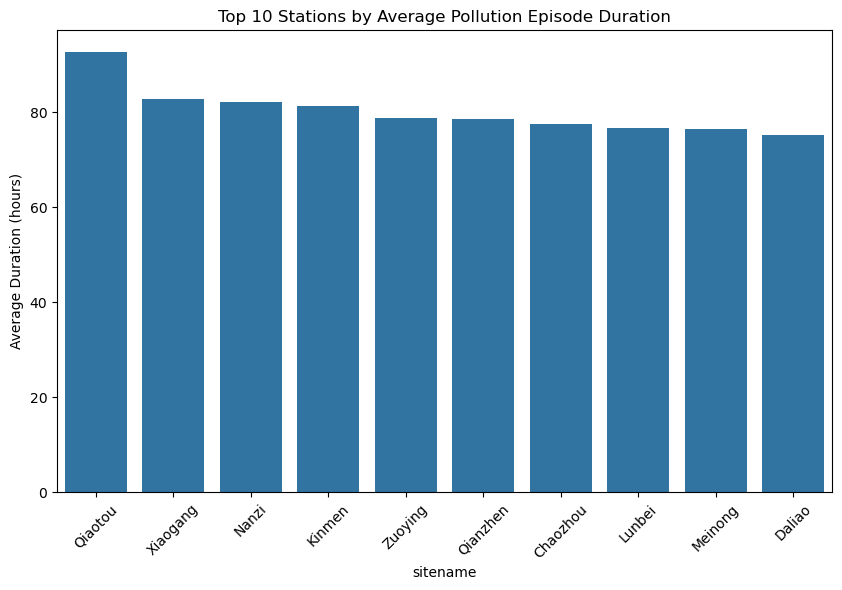

In [25]:
# 1. Top 10 trạm có đợt ô nhiễm dài nhất
# Vẽ bar plot
plt.figure(figsize=(10,6))
sns.barplot(x=top10.index, y=top10['avg_duration'])
plt.xticks(rotation=45)
plt.ylabel("Average Duration (hours)")
plt.title("Top 10 Stations by Average Pollution Episode Duration")
plt.show()

##### Nhận xét về các trạm có nguy cơ cao  (Đợt ô nhiễm kéo dài)

- **Qiaotou** có thời lượng ô nhiễm trung bình cao nhất (~93 giờ) và số đợt lớn (59 đợt), cho thấy ô nhiễm xảy ra **thường xuyên và kéo dài**.

- **Xiaogang, Nanzi, Kinmen** theo sau với thời lượng trung bình khoảng **81–83 giờ**, tương đương hơn **3 ngày liên tục**.

- Các trạm còn lại trong **top 10** có thời lượng trung bình **~75–79 giờ**, vẫn là mức ô nhiễm kéo dài đáng kể.

**Kết luận:** Tất cả các trạm nguy cơ cao đều ghi nhận các đợt ô nhiễm kéo dài nhiều ngày, cho thấy ô nhiễm mang tính **liên tục**, có thể liên quan đến các nguồn phát thải **ổn định**, làm gia tăng rủi ro phơi nhiễm cho khu vực xung quanh. Việc xác định nguyên nhân cụ thể cần bổ sung thêm thông tin về **nguồn phát thải** và **điều kiện khí tượng**.

#### 2. Quy luật mùa vụ 

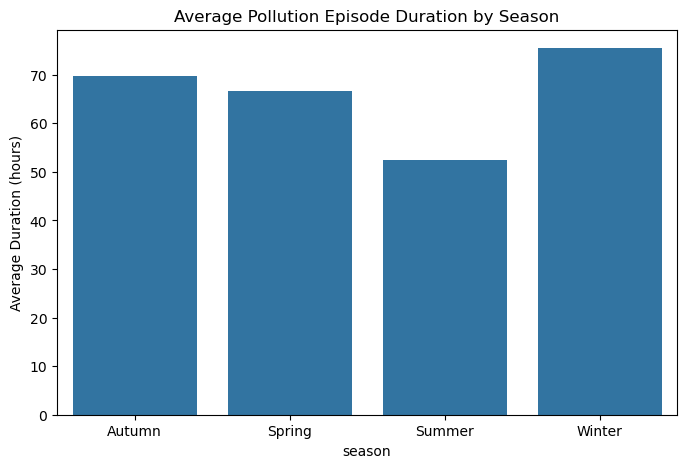

In [26]:
# 2. Thời lượng trung bình theo mùa
plt.figure(figsize=(8,5))
sns.barplot(x=season_summary.index, y=season_summary['avg_duration'])
plt.ylabel("Average Duration (hours)")
plt.title("Average Pollution Episode Duration by Season")
plt.show()

#### Nhận xét về quy luật mùa vụ
##### Mùa Đông (Winter)

- **Thời lượng**: Các đợt ô nhiễm có thời lượng dài nhất, trung bình khoảng **~75.5 giờ** (hơn 3 ngày liên tục), đồng thời có **số đợt ô nhiễm cao nhất**.

- **Giải thích**: Điều kiện khí tượng mùa đông thường kém thuận lợi cho khuếch tán (ví dụ: nghịch nhiệt, gió yếu), khiến các chất ô nhiễm dễ tích tụ và kéo dài thời gian tồn tại.

##### Mùa Hè (Summer)

- **Thời lượng**: Thời lượng ô nhiễm trung bình **ngắn nhất (~52.5 giờ)**.

- **Lưu ý**: Số đợt ô nhiễm ghi nhận trong mùa hè **rất ít (2 đợt)**, do đó kết quả chỉ mang tính tham khảo.

- **Giải thích**: Xu hướng thời lượng ngắn có thể liên quan đến các điều kiện khí tượng thuận lợi như đối lưu mạnh, mưa và gió, giúp làm sạch không khí nhanh hơn.

##### Mùa Xuân (Spring) và Mùa Thu (Autumn)

- **Thời lượng**: Hai mùa này có thời lượng ô nhiễm trung bình tương đối cao và gần nhau, khoảng **~66–70 giờ**.

- **Giải thích**: Đây là các giai đoạn chuyển tiếp khí tượng, với điều kiện phân tán ô nhiễm ở mức trung gian giữa mùa hè và mùa đông.


#### 3. Ứng dụng thực tiễn

- **Cảnh báo y tế**: Tăng cường phát cảnh báo sức khỏe cho cư dân tại các khu vực nguy cơ cao, đặc biệt trong **mùa đông**.

- **Điều phối y tế**: Chủ động tăng cường nhân lực và giường bệnh hô hấp tại các khu vực có trạm thuộc **top nguy cơ trong mùa đông**.

- **Chiến lược giảm phát thải**: Ưu tiên kiểm soát các nguồn phát thải liên tục (khu công nghiệp, khu chế xuất), đặc biệt trong các giai đoạn ô nhiễm kéo dài.

#### 4. Hạn chế

- Dữ liệu có thể bị **thiếu giờ quan trắc**, ảnh hưởng đến việc xác định chính xác thời lượng các đợt ô nhiễm.
- **Mạng lưới trạm đo chưa bao phủ toàn bộ khu vực**, do đó mức độ ô nhiễm tại các vị trí không có trạm có thể khác với kết quả phân tích.
